In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir('/content/drive/My Drive/ML')

# LSTM text classifier by Oleksandra Oleksiichuk
RNN model to classify a text as one of 4 genres and compare the result to **Naive Bayes model accuracy of  0.69**

### Importing libraries

In [0]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
nltk.download('stopwords')
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from gensim.models import KeyedVectors

# Sklearn
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, SpatialDropout1D
from keras.optimizers import RMSprop, Adam
from keras import backend as K


%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Preprocessing text

In [0]:
# Genres where I added more texts for better accuracy with EXACT number for each genre
genres = ['DETECT', 'FANTAST', 'RELIGION', 'TALES']

In [0]:
# creating a dictionary with genres as keys and texts as values
import glob
path = 'ENGLISH/'
texts = {}

for genre in genres:
  texts[genre] = {}
  inpath = path + genre
  for filename in glob.glob(os.path.join(inpath, '*.TXT')):    
    try:
      with open(filename, 'r', encoding='utf-8') as f:      
        texts[genre][filename.split('/')[-1]] = ''.join(f.readlines())
    except:      
      with open(filename, 'r', encoding='latin-1') as f:      
        texts[genre][filename.split('/')[-1]] = ''.join(f.readlines())
      

In [0]:
# number of texts in each selected genre
for genre in texts:
  print(genre + ": " + str(len(texts[genre])))
  

DETECT: 28
FANTAST: 28
RELIGION: 28
TALES: 28


In [0]:
def clean_text(text):
    # Remove links
    text = BeautifulSoup(text, 'html.parser').get_text()
    
    # Remove punctuation
    text = text.translate(string.punctuation)
    
    # Convert words to lower case and split them
    text = text.lower().split()
    
    # Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    
    text = " ".join(text)
    
    # Clean the text
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text)
    
    # Stemming
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    return text

In [0]:
# cleaning all texts
for genre in texts:
  for text in texts[genre]:    
    texts[genre][text] = clean_text(texts[genre][text])
    
print('Finished cleaning')  

Finished cleaning


### Creating a Data Frame

In [0]:
# creating a data frame with text and labels columns
columns = ['text', 'labels']
df = pd.DataFrame(columns=columns)

In [0]:
for genre in texts:
  for text in texts[genre]: 
    df = df.append({'text': texts[genre][text], 'labels': genre}, ignore_index=True)

In [0]:
df.head()

,text,labels
0,cockoo egg clifford stoll week befor astronom ...,DETECT
1,obi doyl valley of fear txt part 1 tragedi bir...,DETECT
2,the memoir sherlock holm arthur conan doyl obi...,DETECT
3,his last bow arthur conan doyl obi doyl his la...,DETECT
4,obi doyl hound of baskervill txt chapter 1 mr ...,DETECT


### Encoding text and labels

In [0]:
# encoding labels and splitting data to test and train sets
X = df.text.values
Y = df['labels'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

encoder = LabelEncoder()
train_labels = encoder.fit_transform(Y_train)
test_labels = encoder.fit_transform(Y_test)

train_labels = train_labels.reshape(-1,1)
test_labels = test_labels.reshape(-1,1)

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [0]:
test_labels.shape

(12, 4)

In [0]:
# Create sequences for train and test sets
MAX_WORDS = 60000
EMBEDDING_DIM = 300
tok = Tokenizer(num_words=MAX_WORDS)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X_train)
word_index = tok.word_index
print('Found %s unique tokens' % len(word_index))

Found 52507 unique tokens


In [0]:
MAX_SEQUENCE_LENGTH = 5000
sequences_matrix = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print(sequences_matrix)
print('Shape of data tensor:', sequences_matrix.shape)

[[   38   350   602 ...   382  1348  2980]
 [ 1075  6931   100 ...   227   243  1017]
 [  272  2513    34 ...   163 11144   181]
 ...
 [13777  5764  1954 ...   227   243  1017]
 [   30    13  1070 ...  1387  2057  1017]
 [ 2223   497  1640 ...   140     5    14]]
Shape of data tensor: (100, 5000)


In [0]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=MAX_SEQUENCE_LENGTH)

In [0]:
nb_words = min(MAX_WORDS, len(word_index))+1
print(nb_words)

52508


### Building a model

Making a base model

In [0]:
model = Sequential()
model.add(Embedding(nb_words, 300, input_length=MAX_SEQUENCE_LENGTH))
model.add(LSTM(64))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))


### Compiling a model

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              

### Training a model

In [0]:
hist = model.fit(sequences_matrix, train_labels,
                 batch_size=50,
                 epochs=20,
                 verbose=0,
                 validation_split=0.1)

In [0]:
# checking the history
history_dict = hist.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

**Plotting the training and validation loss**

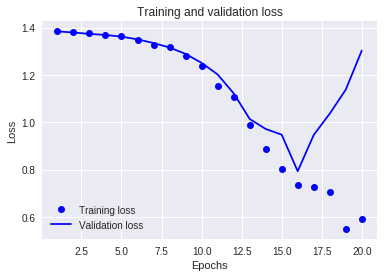

In [0]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

After 15 epochs model is overfitting

**Plotting the training and validation accuracy**

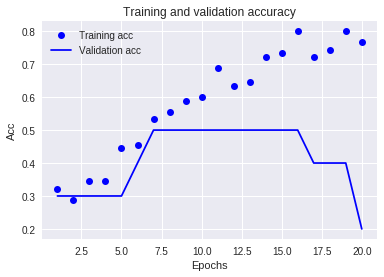

In [0]:
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

In [0]:
accr = model.evaluate(test_sequences_matrix, test_labels)
print(accr)

12/12 [==============================] - 1s 77ms/step
[1.1173696517944336, 0.3333333432674408]


## Building a new model

### Using GridSearch to find best parameters

In [0]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

def create_network(optimizer='rmsprop'):
  model = Sequential()
  model.add(Embedding(nb_words, 300, input_length=MAX_SEQUENCE_LENGTH))
  model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
  model.add(Dense(4, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
  
  return model

neural_network = KerasClassifier(build_fn=create_network, verbose=1)

epochs = [5, 10, 15]
batches = [10, 20, 50]
optimizers = ['rmsprop', 'adam']

hyperparams = dict(optimizer=optimizers, epochs=epochs, batch_size=batches)

In [0]:
grid = GridSearchCV(estimator=neural_network, param_grid=hyperparams)

In [0]:
grid_result = grid.fit(sequences_matrix, train_labels)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [0]:
# View hyperparameters of best neural network

grid_result.best_params_

{'batch_size': 20, 'epochs': 15, 'optimizer': 'rmsprop'}

In [0]:
model = Sequential()
model.add(Embedding(nb_words, 300, input_length=MAX_SEQUENCE_LENGTH))
model.add(LSTM(64, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
hist = model.fit(sequences_matrix, train_labels,
                 batch_size=20,
                 epochs=15,
                 #verbose=0,
                 validation_split=0.1)

Train on 90 samples, validate on 10 samples
Epoch 1/15
90/90 [==============================] - 35s 387ms/step - loss: 1.3817 - acc: 0.2333 - val_loss: 1.3646 - val_acc: 0.2000
Epoch 2/15
90/90 [==============================] - 32s 360ms/step - loss: 1.3304 - acc: 0.6000 - val_loss: 1.3298 - val_acc: 0.2000
Epoch 3/15
90/90 [==============================] - 33s 366ms/step - loss: 1.2666 - acc: 0.7111 - val_loss: 1.2650 - val_acc: 0.5000
Epoch 4/15
90/90 [==============================] - 33s 361ms/step - loss: 1.1839 - acc: 0.6778 - val_loss: 1.2123 - val_acc: 0.5000
Epoch 5/15
90/90 [==============================] - 32s 360ms/step - loss: 1.0978 - acc: 0.6778 - val_loss: 1.1746 - val_acc: 0.5000
Epoch 6/15
90/90 [==============================] - 33s 362ms/step - loss: 1.0357 - acc: 0.6889 - val_loss: 1.1070 - val_acc: 0.5000
Epoch 7/15
90/90 [==============================] - 33s 364ms/step - loss: 0.9686 - acc: 0.7444 - val_loss: 1.1326 - val_acc: 0.5000
Epoch 8/15
90/90 [=======

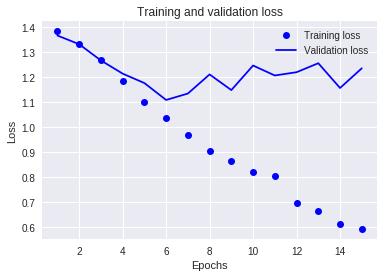

In [0]:
# Loss
history_dict = hist.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

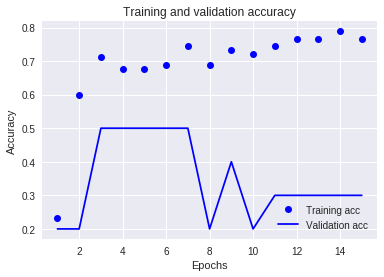

In [0]:
# Accuracy
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Model evaluation

In [0]:
accr = model.evaluate(test_sequences_matrix, test_labels)
print(accr)

12/12 [==============================] - 1s 82ms/step
[1.0290836095809937, 0.5]


In [0]:
Y_test

array(['DETECT', 'TALES', 'RELIGION', 'TALES', 'RELIGION', 'RELIGION',
       'DETECT', 'FANTAST', 'TALES', 'TALES', 'TALES', 'DETECT'],
      dtype=object)

## Confusion matrix

In [0]:
# convert model predictions to genre labels
def to_labels(y_list):
  Y_labels = [np.argmax(y, axis=None, out=None) for y in y_list]
  Y_labels = encoder.inverse_transform(Y_labels)
  return Y_labels

Y_predicted = model.predict(test_sequences_matrix)
Y_plabels = to_labels(Y_predicted)
Y_plabels

array(['FANTAST', 'FANTAST', 'RELIGION', 'TALES', 'FANTAST', 'FANTAST',
       'FANTAST', 'RELIGION', 'FANTAST', 'RELIGION', 'RELIGION',
       'FANTAST'], dtype=object)

In [0]:
print('Classification Report:')
print(classification_report(Y_test, Y_plabels))

Classification Report:
              precision    recall  f1-score   support

      DETECT       0.00      0.00      0.00         2
     FANTAST       0.43      1.00      0.60         3
    RELIGION       0.75      0.75      0.75         4
       TALES       0.00      0.00      0.00         3

   micro avg       0.50      0.50      0.50        12
   macro avg       0.29      0.44      0.34        12
weighted avg       0.36      0.50      0.40        12



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


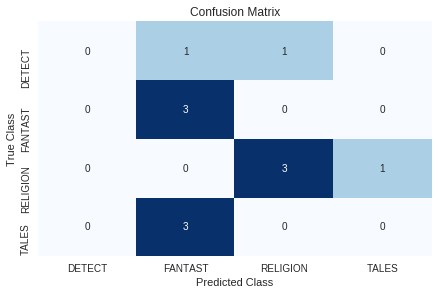

In [0]:
matrix = confusion_matrix(Y_test, Y_plabels)

dataframe = pd.DataFrame(matrix, index=genres, columns=genres)

sns.heatmap(dataframe, annot=True, cbar=None, cmap='Blues')
plt.title('Confusion Matrix'), plt.tight_layout()
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

plt.show()


## Model without Embedding layer

### Using CountVectorizer

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

X = df.text.values
Y = df['labels'].values

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# Encoding labels
encoder = LabelEncoder()
train_labels = encoder.fit_transform(Y_train)
test_labels = encoder.fit_transform(Y_test)

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [0]:
vectorizer.fit(X_train)   # Fitting only train set

X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)
X_train

<89x48024 sparse matrix of type '<class 'numpy.int64'>'
	with 380572 stored elements in Compressed Sparse Row format>

In [0]:
input_dim = X_train.shape[1]
input_dim

48024

### Dense Model

In [0]:
model = Sequential()
model.add(Dense(48, input_dim=input_dim, activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
hist = model.fit(X_train, train_labels,
                 batch_size=20,
                 epochs=10,
                 #verbose=0,
                 validation_split=0.1)

Train on 80 samples, validate on 9 samples
Epoch 1/10
80/80 [==============================] - 1s 19ms/step - loss: 9.2698 - acc: 0.2625 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 2/10
80/80 [==============================] - 0s 2ms/step - loss: 7.7759 - acc: 0.2750 - val_loss: 9.9662 - val_acc: 0.3333
Epoch 3/10
80/80 [==============================] - 0s 2ms/step - loss: 8.3736 - acc: 0.4125 - val_loss: 6.5211 - val_acc: 0.4444
Epoch 4/10
80/80 [==============================] - 0s 2ms/step - loss: 5.3958 - acc: 0.4875 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 5/10
80/80 [==============================] - 0s 2ms/step - loss: 7.1387 - acc: 0.4625 - val_loss: 1.4038 - val_acc: 0.8889
Epoch 6/10
80/80 [==============================] - 0s 2ms/step - loss: 3.1864 - acc: 0.7750 - val_loss: 1.2176 - val_acc: 0.6667
Epoch 7/10
80/80 [==============================] - 0s 2ms/step - loss: 3.2353 - acc: 0.6375 - val_loss: 8.9574 - val_acc: 0.4444
Epoch 8/10
80/80 [==========================

In [0]:
accr = model.evaluate(X_test, test_labels)
print(accr)

23/23 [==============================] - 0s 746us/step
[0.541500449180603, 0.9130434989929199]


In [0]:
# convert model predictions to genre labels
def to_labels(y_list):
  Y_labels = [np.argmax(y, axis=None, out=None) for y in y_list]
  Y_labels = encoder.inverse_transform(Y_labels)
  return Y_labels

Y_predicted = model.predict(X_test)
Y_plabels = to_labels(Y_predicted)
Y_plabels

array(['DETECT', 'DETECT', 'DETECT', 'TALES', 'RELIGION', 'TALES',
       'RELIGION', 'TALES', 'RELIGION', 'FANTAST', 'RELIGION', 'FANTAST',
       'TALES', 'DETECT', 'RELIGION', 'FANTAST', 'FANTAST', 'FANTAST',
       'TALES', 'RELIGION', 'TALES', 'FANTAST', 'FANTAST'], dtype=object)

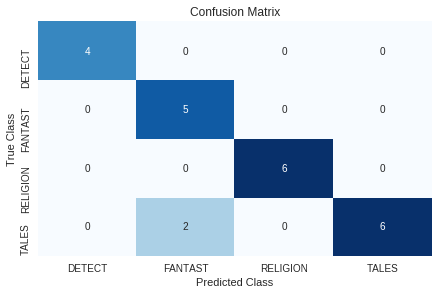

In [0]:
matrix = confusion_matrix(Y_test, Y_plabels)

dataframe = pd.DataFrame(matrix, index=genres, columns=genres)

sns.heatmap(dataframe, annot=True, cbar=None, cmap='Blues')
plt.title('Confusion Matrix'), plt.tight_layout()
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

plt.show()

Model has a trouble of distinguishing a Fantasy genre from Tales.